<a href="https://colab.research.google.com/github/Serge3leo/temp-cola/blob/main/SO/77889635-fast-implementation-of-the-1-parameter-division-distortion-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# import time
# osx_start = time.time()
# try:
#     %matplotlib osx
# except Exception as exc:
#     print(f"{time.time() - osx_start, exc=}")
#     time.sleep(0.05)
#     %matplotlib osx
# %matplotlib osx
# %matplotlib ipympl
# %matplotlib inline
%config InlineBackend.figure_format = 'retina'

import platform
import tempfile

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Single-parameter distortion

Single-parameter models by  [Andrew W Fitzgibbon, Simultaneous linear
estimation of multiple view geometry and lens distortion](
https://www.robots.ox.ac.uk/%7Evgg/publications/2001/Fitzgibbon01b/fitzgibbon01b.pdf)

Notation by Fitzgibbon:
- $\overrightarrow{p}$ - ideal point;
- $\overrightarrow{x}$ - point in the image distorted by distortion.

## The division model

$$\overrightarrow{x} = \frac{1}{\left( 1 + \lambda \left\| \overrightarrow{p} \right\|^2 \right)} \overrightarrow{p}$$

In [16]:
_division_atol = 0.1
_division_citeria = (cv2.TermCriteria_COUNT + cv2.TermCriteria_EPS,
                     10,  # 5 for cv2.undistortPoints()
                     0.1)

def division_distorted(p, k, dc=[0, 0], verbose=False):
    p = p - dc
    return p/(1 + k*np.dot(p, p)) + dc

def division_undistorted(x, k, dc=[0, 0], criteria=_division_citeria,
                        verbose=False):
    p0 = x - dc
    for i in range(criteria[1] if criteria[0]&cv2.TermCriteria_COUNT
                   else 99999):
        p = x*(1 + k*np.dot(p0, p0))
        if verbose:
            print(f"division_undistorted: {i}: {np.round(p - p0, 3)}")
        if ((criteria[0]&cv2.TermCriteria_EPS) and
            np.linalg.norm(p - p0) < criteria[2]):
            # This is inaccurate, simplistic, OpenCV compares projections
            break
        p0 = p
    return p + dc

test_corner = np.array([200, 200])
test_px = np.array([[0, 0], [50, 50], [200, 200]], dtype=float)
test_k = 0.3/np.dot(test_corner, test_corner)
for p in test_px:
    p = np.asarray(p)
    np.testing.assert_allclose(p,
            division_undistorted(division_distorted(p, test_k),
                                 test_k, verbose=False),
            atol=_division_atol)
test_cameraMatrix = np.identity(3)
test_div_distCoeffs = np.asarray([0, 0, 0, 0, 0, test_k, 0, 0])
test_div_cv_p = cv2.undistortPoints(test_px, test_cameraMatrix,
                                    test_div_distCoeffs)
test_div_p = [division_undistorted(x, test_k, verbose=False,
                                   criteria=(cv2.TermCriteria_COUNT, 5, 0))
              for x in test_px]
np.testing.assert_allclose(test_div_cv_p[:,0,:],
                           test_div_p, atol=_division_atol)
test_div_cv_p = cv2.undistortPointsIter(test_px, test_cameraMatrix,
                                        test_div_distCoeffs, R=None, P=None,
                                        criteria=_division_citeria)
test_div_p = [division_undistorted(x, test_k, verbose=False,)
              for x in test_px]
np.testing.assert_allclose(test_div_cv_p[:,0,:],
                           test_div_p, atol=_division_atol)
print("Хорь")

Хорь


## The usual 3rd order

According to the Taylor series (there are no even orders):
$$\overrightarrow{x} = \left( 1 + \lambda \left\| \overrightarrow{p} \right\|^2 \right) \overrightarrow{p}$$

In [17]:
_taylor3_atol = 0.1
_taylor3_citeria = (cv2.TermCriteria_COUNT + cv2.TermCriteria_EPS,
                    10,  # 5 for cv2.undistortPoints()
                    0.1)

def taylor3_distorted(p, k, dc=[0, 0], verbose=False):
    p = p - dc
    return p*(1 + k*np.dot(p, p)) + dc

def taylor3_undistorted(x, k, dc=[0, 0], criteria=_taylor3_citeria,
                        verbose=False):
    p0 = x - dc
    for i in range(criteria[1] if criteria[0]&cv2.TermCriteria_COUNT
                   else 99999):
        p = x/(1 + k*np.dot(p0, p0))
        if verbose:
            print(f"taylor3_undistorted: {i}: {np.round(p - p0, 3)}")
        if ((criteria[0]&cv2.TermCriteria_EPS) and
            np.linalg.norm(p - p0) < criteria[2]):
            # This is inaccurate, simplistic, OpenCV compares projections
            break
        p0 = p
    return p + dc

for p in test_px:
    np.testing.assert_allclose(p,
            taylor3_undistorted(taylor3_distorted(p, test_k),
                                test_k, verbose=False),
            atol=_taylor3_atol)
test_t3_distCoeffs = np.asarray([test_k, 0, 0, 0])
test_t3_cv_p = cv2.undistortPoints(test_px, test_cameraMatrix,
                                   test_t3_distCoeffs)
test_t3_p = [taylor3_undistorted(x, test_k, verbose=False,
                                 criteria=(cv2.TermCriteria_COUNT, 5, 0))
             for x in test_px]
np.testing.assert_allclose(test_t3_cv_p[:,0,:],
                           test_t3_p, atol=_taylor3_atol)
test_t3_cv_p = cv2.undistortPointsIter(test_px, test_cameraMatrix,
                                       test_t3_distCoeffs, R=None, P=None,
                                       criteria=_taylor3_citeria)
test_t3_p = [taylor3_undistorted(x, test_k, verbose=False,)
             for x in test_px]
np.testing.assert_allclose(test_div_cv_p[:,0,:],
                           test_div_p, atol=_taylor3_atol)
print("Хорь")

Хорь


## Images

Based on [Fast Implementation of the 1 Parameter Division Distortion Model](https://stackoverflow.com/q/77889635/8585880)

In [18]:
org = np.full((*(test_corner*2), 3), 255, dtype=np.uint8)
dis = org.copy()
und = org.copy()
thick=3
dis_und_func=division_distorted
dis_und_k=test_k
# dis_und_func=taylor3_distorted
# dis_und_k=-test_k

limits = (50, org.shape[0] - 50)
xy = np.linspace(limits[0], limits[1], num=9, dtype=int)
for i in range(xy.shape[0]):
    for j in range(xy.shape[0]):
        if i + 1 < xy.shape[0]:
            cv2.line(org, (xy[i], xy[j]), (xy[i + 1], xy[j]), (0, 0, 0), thickness=thick)
            x = np.linspace(xy[i], xy[i + 1], 5, dtype=int)
            for l in range(x.shape[0] - 1):
                a = dis_und_func((x[l], xy[j]), dis_und_k, dc=test_corner)
                b = dis_und_func((x[l + 1], xy[j]), dis_und_k, dc=test_corner)
                cv2.line(dis, (int(a[0]), int(a[1])),
                              (int(b[0]), int(b[1])), (0, 0, 0), thickness=thick)
        if j + 1 < xy.shape[0]:
            cv2.line(org, (xy[i], xy[j]), (xy[i], xy[j + 1]), (0, 0, 0), thickness=thick)
            y = np.linspace(xy[j], xy[j + 1], 5, dtype=int)
            for l in range(y.shape[0] - 1):
                a = dis_und_func((xy[i], y[l]), dis_und_k, dc=test_corner)
                b = dis_und_func((xy[i], y[l + 1]), dis_und_k, dc=test_corner)
                cv2.line(dis, (int(a[0]), int(a[1])),
                              (int(b[0]), int(b[1])), (0, 0, 0), thickness=thick)

In [19]:
dis_und_cameraMatrix = np.array([[1., 0., test_corner[0]],
                                 [0., 1., test_corner[1]],
                                 [0., 0., 1.]])
dis_und_distCoeffs = np.asarray([0, 0, 0, 0, 0, test_k, 0, 0])
_ = cv2.undistort(dis, dis_und_cameraMatrix, dis_und_distCoeffs, und)
assert 0.28 >= (np.sum(np.abs(np.float32(org) - np.float32(und)))/
                np.sum(np.abs(np.float32(org) - np.float32(dis))))  # TODO

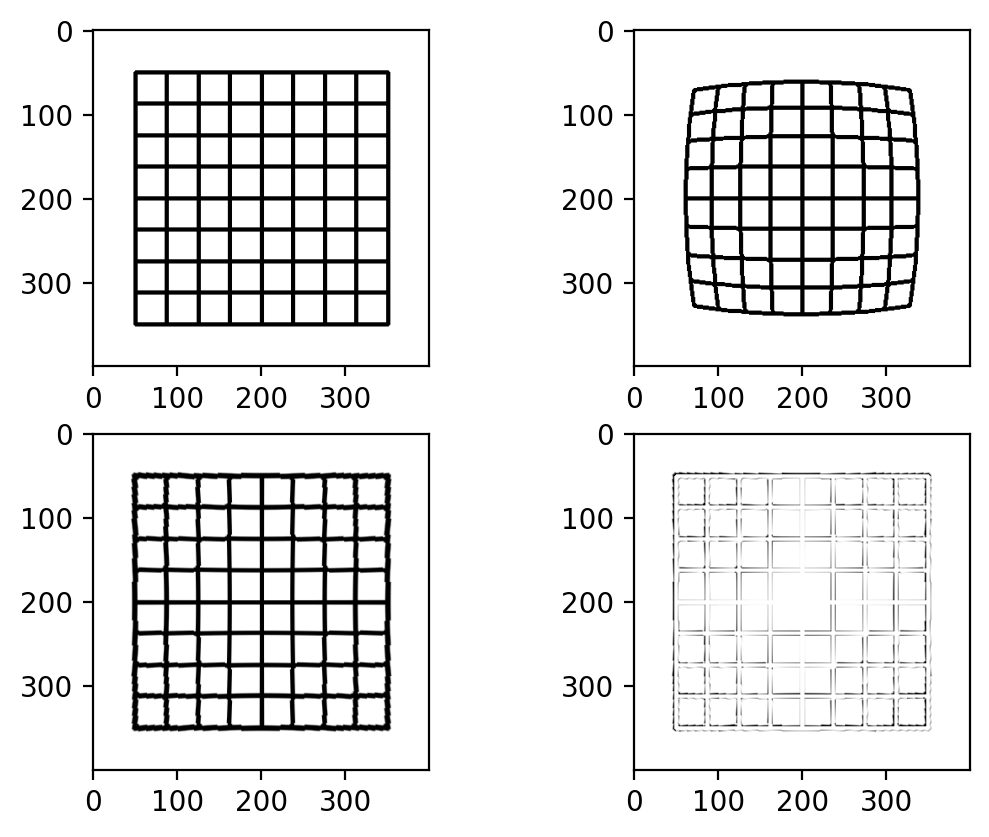

In [20]:
fig, ax = plt.subplot_mosaic([["org", "dis"],
                              ["und", "dif"]])
iorg = ax["org"].imshow(org)
idis = ax["dis"].imshow(dis)
iund = ax["und"].imshow(und)
idif = ax["dif"].imshow(255 - (und ^ org))
plt.show()

# Performance


## undistort (OpenCV)

In [21]:
print(f"cv2.undistort: {dis.shape, dis.dtype=}")
%timeit cv2.undistort(dis, dis_und_cameraMatrix, dis_und_distCoeffs, und)
dis_f32 = np.float32(dis)
und_f32 = np.float32(und)  # Preallocate
print(f"cv2.undistort: {dis_f32.shape, dis_f32.dtype=}")
%timeit cv2.undistort(dis_f32, dis_und_cameraMatrix, dis_und_distCoeffs, und_f32)
dis_f64 = np.float64(dis)
und_f64 = np.float64(und)  # Preallocate
print(f"cv2.undistort: {dis_f64.shape, dis_f64.dtype=}")
%timeit cv2.undistort(dis_f64, dis_und_cameraMatrix, dis_und_distCoeffs, und_f64)

cv2.undistort: dis.shape, dis.dtype=((400, 400, 3), dtype('uint8'))
3.22 ms ± 91.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
cv2.undistort: dis_f32.shape, dis_f32.dtype=((400, 400, 3), dtype('float32'))
4.05 ms ± 84.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
cv2.undistort: dis_f64.shape, dis_f64.dtype=((400, 400, 3), dtype('float64'))
6.06 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## RegularGridInterpolator (SciPy)

In [22]:
temp_delete_on_close = not platform.system().startswith("Win")
tempf = tempfile.NamedTemporaryFile(suffix='.png',
                                    #delete_on_close=temp_delete_on_close,
                                    delete=True)
tempf.file.write(b"For temp PNG\n")
if not temp_delete_on_close:
    tempf.file.close()
cv2.imwrite(tempf.name, org)

True

Copy of (answer Jan 27, 2024 at 21:30 Reinderien)[https://stackoverflow.com/a/77892886]

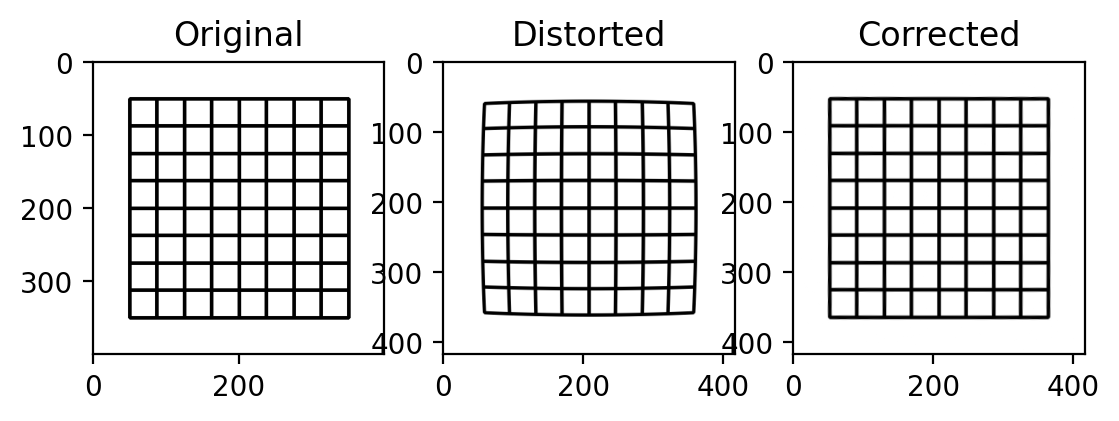

In [23]:
from typing import NamedTuple

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy.interpolate import RegularGridInterpolator


class Transform(NamedTuple):
    mn_high: tuple[int, int]
    interp_grid: tuple[np.ndarray, np.ndarray]
    yxdistort: np.ndarray
    yxfixed: np.ndarray
    rect_axes: tuple[np.ndarray, np.ndarray]

    @classmethod
    def setup(
        cls,
        dc: np.ndarray,
        k: float,
        mn: tuple[int, int],
        scale: float,
    ) -> 'Transform':
        ylong = np.arange(0, mn[0], scale)
        xlong = np.arange(0, mn[1], scale)
        yxrect_d3 = np.stack(
            np.meshgrid(xlong, ylong), axis=-1,
        )
        yxrect = yxrect_d3.reshape((-1, 2))[:, ::-1]

        interp_grid = tuple(
            dim.ravel()
            for dim in np.indices(dimensions=mn, sparse=True)
        )

        return cls(
            mn_high=yxrect_d3.shape[:2],
            interp_grid=interp_grid,
            yxdistort=redistort(dc=dc, k=k, vu=yxrect),
            yxfixed=undistort(dc=dc, k=k, yx=yxrect),
            rect_axes=(ylong, xlong),
        )

    def distort_image(self, image: np.ndarray) -> np.ndarray:
        distort_interp = RegularGridInterpolator(
            points=self.interp_grid, values=image, bounds_error=False,
        )
        return distort_interp(self.yxdistort).reshape(
            (*self.mn_high, -1)
        )

    def undistort_image(self, image: np.ndarray) -> np.ndarray:
        undistort_interp = RegularGridInterpolator(
            points=self.rect_axes, values=image, bounds_error=False,
        )
        return undistort_interp(self.yxfixed).reshape(
            (*self.mn_high, -1)
        )


def undistort(
    dc: np.ndarray,  # centre point, *2
    k: float,        # distort parameter aka. lambda
    yx: np.ndarray,  # distorted, n * 2
) -> np.ndarray:     # n * 2
    r2 = ((yx - dc)**2).sum(axis=1, keepdims=True)
    vu = dc + (yx - dc)/(1 + k*r2)
    return vu


def redistort(
    dc: np.ndarray,  # centre point, *2
    k: float,        # distort parameter aka. lambda
    vu: np.ndarray,  # non-distorted, n * 2
) -> np.ndarray:     # n * 2
    inner = k*((vu - dc)**2).sum(axis=1, keepdims=True)

    return (
        k*(
            dc*(
                + (vu**2).sum(axis=1, keepdims=True)
                - 2*dc*vu
                + dc**2
                + dc[::-1]**2
            )
            - 2*dc.prod()*vu[:, ::-1]
        )
        + 0.5*(vu - dc)*(
            1 - np.sqrt(1 - 4*inner)
        )
    )/inner


def regression_test() -> None:
    dcx = 320/2
    dcy = 240/2
    xd = 5
    yd = 17
    lambd = 1e-6

    r2 = (dcx - xd)**2 + (dcy - yd)**2
    xu = dcx + (xd - dcx)/(1 + lambd*r2)
    yu = dcy + (yd - dcy)/(1 + lambd*r2)

    dc = np.array((dcy, dcx))
    actual = undistort(
        dc=dc, k=lambd, yx=np.array((
            (yd, xd),
        )),
    )
    assert np.allclose(actual, (yu, xu))

    vu = np.array((
        (yu, xu),
        (40, 30),
        (25, 20),
    ))
    expected = np.array((
        (         yd,          xd),
        (38.04372287, 26.82104966),
        (22.11282237, 15.74521192),
    ))
    actual = redistort(dc, lambd, vu)
    assert np.allclose(expected, actual, rtol=0, atol=1e-8)


def estimate_resolution_loss(
    mn: tuple[int, int],
    dc: np.ndarray,
    k: float,
) -> float:
    # Pretty bad! This is not efficient.
    n = 200
    middle_strip = np.empty((n, 2))
    middle_strip[:, 0] = np.linspace(0, mn[0]-1, n)
    middle_strip[:, 1] = mn[1]/2

    distorted = redistort(dc=dc, k=k, vu=middle_strip)
    y, x = distorted.T
    y = y[np.isfinite(y)]

    res_reduce = mn[0]/(y.max() - y.min())
    return res_reduce


def roundtrip_demo(filename: str) -> None:
    # Once per parameter+resolution set
    imorig = np.array(Image.open(filename))
    mn = imorig.shape[:2]
    dc = 0.5*np.array(mn) + 0.1  # avoid a divide-by-zero
    k = 1e-6
    res_reduce = estimate_resolution_loss(mn=mn, dc=dc, k=k)
    transform = Transform.setup(mn=mn, dc=dc, k=k, scale=res_reduce)

    # Once every frame
    imdistort = transform.distort_image(imorig/255)
    imfixed = transform.undistort_image(imdistort)

    fig, (ax_orig, ax_distort, ax_fixed) = plt.subplots(ncols=3)
    ax_orig.imshow(imorig)
    ax_distort.imshow(imdistort)
    ax_fixed.imshow(imfixed)
    ax_orig.set_title('Original')
    ax_distort.set_title('Distorted')
    ax_fixed.set_title('Corrected')
    plt.show()


if __name__ == '__main__':
    regression_test()
    roundtrip_demo(tempf.name)

In [24]:
del tempf

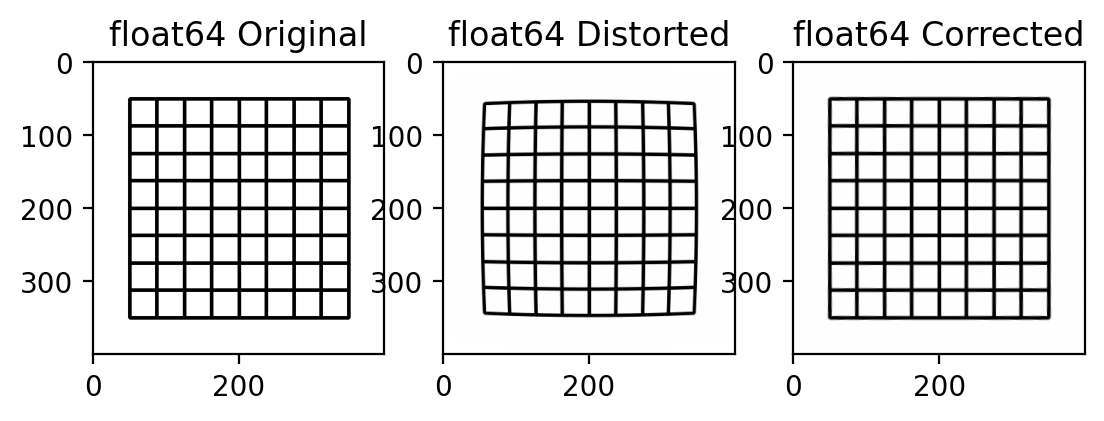

transform.undistort_image: imdistort.shape, imdistort.dtype=((400, 400, 3), dtype('float64'))
48.9 ms ± 817 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
transform_timeit_debug = True
imorig = org.copy()
mn = imorig.shape[:2]
dc = 0.5*np.array(mn) + 0.1  # avoid a divide-by-zero
k = 1e-6
transform = Transform.setup(mn=mn, dc=dc, k=k, scale=1)
# Once every frame
imdistort = transform.distort_image(imorig/256)
if transform_timeit_debug:
    imfixed = transform.undistort_image(imdistort)

    fig, (ax_orig, ax_distort, ax_fixed) = plt.subplots(ncols=3)
    ax_orig.imshow(imorig)
    ax_distort.imshow(imdistort)
    ax_fixed.imshow(imfixed)
    ax_orig.set_title('float64 Original')
    ax_distort.set_title('float64 Distorted')
    ax_fixed.set_title('float64 Corrected')
    plt.show()
print(f"transform.undistort_image: {imdistort.shape, imdistort.dtype=}")
%timeit transform.undistort_image(imdistort)

/tmp/ipython-input-26-2522098027.py:1: RuntimeWarning: invalid value encountered in cast
  imdistort = np.uint8(np.clip(transform.distort_image(imorig), 0, 255))


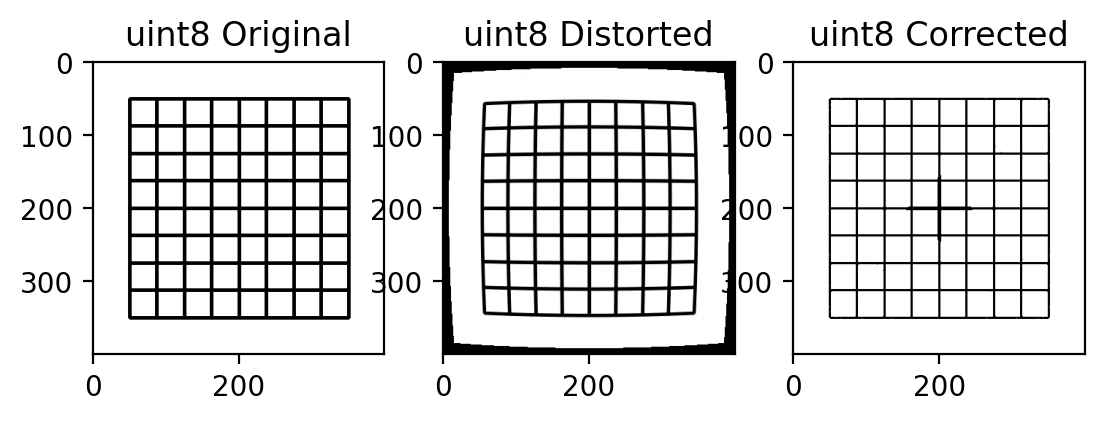

transform.undistort_image: imdistort.shape, imdistort.dtype=((400, 400, 3), dtype('uint8'))
59.6 ms ± 9.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
imdistort = np.uint8(np.clip(transform.distort_image(imorig), 0, 255))
if transform_timeit_debug:
    imfixed = transform.undistort_image(imdistort)

    fig, (ax_orig, ax_distort, ax_fixed) = plt.subplots(ncols=3)
    ax_orig.imshow(imorig)
    ax_distort.imshow(imdistort)
    ax_fixed.imshow(imfixed)
    ax_orig.set_title('uint8 Original')
    ax_distort.set_title('uint8 Distorted')
    ax_fixed.set_title('uint8 Corrected')
    plt.show()
print(f"transform.undistort_image: {imdistort.shape, imdistort.dtype=}")
%timeit transform.undistort_image(imdistort)

## Result

`cv2.undistort` is more performance than `RegularGridInterpolator', by factor:

In [28]:
48.9/6.06, 59.6/3.22

(8.06930693069307, 18.509316770186334)